In [1]:
from config import args
from pytorch_lightning import Trainer, loggers
from models import get_pl_model
from augmentations import get_transforms
from datasets import get_train_val_dataloaders
import warnings 
warnings.filterwarnings(action= 'ignore')

# Get augmentation

In [2]:
# transform_train=get_transforms('cf')
transform_train=get_transforms('cfc')
transform_val=get_transforms('r256')

# Get data loaders

In [3]:
train_dataloader, val_dataloader = get_train_val_dataloaders(transform_train=transform_train, transform_val=transform_val, include_massachusetts=False)

# Get model

In [4]:
# model = get_pl_model('unet')
model = get_pl_model('edgemap_fused_unet')
# model = get_pl_model('deeplabv3plus')

# Tensorboard

In [5]:
%load_ext tensorboard
%tensorboard --logdir logs

# Train model

In [ ]:
model=model.train()
args.gpus = None # Remove this line if you actually have gpus

tb_logger = loggers.TensorBoardLogger(save_dir="logs/")
trainer = Trainer(gpus=args.gpus,
                  max_epochs=args.epochs, 
                  logger=tb_logger,
                  # accelerator=args.accelerator,
                  resume_from_checkpoint=args.checkpoint_path,
                  log_every_n_steps=10
)
trainer.fit(model, train_dataloader, val_dataloader)

 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | EdgemapFusedModel | 24.4 M
--------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.759    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Visualize

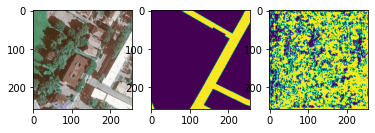

In [6]:
import matplotlib.pyplot as plt
import torch

img, mask = train_dataloader.dataset[10]
pred_mask=model.predict(torch.Tensor(img[None,:])).detach().numpy()
f, axarr = plt.subplots(1,3)
_ = axarr[0].imshow(img.transpose(1,2,0))
_ = axarr[1].imshow(mask.transpose(1,2,0))
_ = axarr[2].imshow(pred_mask.transpose(1,2,0))